In [1]:
# Pytorch packages
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

# Other packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import meshio

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
class Geometry():
    def __init__(self, mesh_file):

        self.mesh = meshio.read(mesh_file)
        self.node_pos = torch.tensor(self.mesh.points[:, :2], dtype=torch.float, device=device)
        self.mesh_size = self.mesh.points.shape[0]

        self.create_graph()

    def create_graph(self):
        edges = []
        for cell in self.mesh.cells:
            if cell.type == "triangle":
                for element in cell.data:
                    edges.append([element[0], element[1]])
                    edges.append([element[1], element[0]])

                    edges.append([element[1], element[2]])
                    edges.append([element[2], element[1]])

                    edges.append([element[2], element[0]])
                    edges.append([element[0], element[2]])

        edges = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
        
        source_nodes = edges[0]
        target_nodes = edges[1]

        source_pos = self.node_pos[source_nodes]
        target_pos = self.node_pos[target_nodes]
        edge_length = torch.norm(source_pos - target_pos, dim=1, keepdim=True)
        
        self.graph = Data(x=self.node_pos, edge_index=edges, edge_attr=edge_length).to(device)

        print(self.graph)
        

In [113]:
class MPNN(pyg_nn.MessagePassing):
    def __init__(self, latent_size, in_edge_size, in_node_size):
        super(MPNN, self).__init__(aggr="add")
        
        self.latent_size = latent_size

        self.edge_net = nn.Sequential(
            nn.Linear(in_edge_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

        self.node_net = nn.Sequential(
            nn.Linear(in_node_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )

    def forward(self, x, edge_index, edge_attr):
        aggr_messages = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        updated_nodes = self.node_net(torch.cat([x, aggr_messages], dim=1))

        row, col = edge_index
        updated_edges = self.edge_net(torch.cat([x[row], x[col], edge_attr], dim=1))

        return updated_nodes, updated_edges
    
    def message(self, x_i, x_j, edge_attr):
        msg = torch.cat([x_i, x_j, edge_attr], dim=1)
        return self.edge_net(msg)
    
    def update(self, aggr_out):
        return aggr_out
    

class EncodeProcessDecode(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, latent_size, output_size, num_layers):
        super(EncodeProcessDecode, self).__init__()

        self.latent_size = latent_size

        # Node encoder: maps raw node features to latent space.
        self.node_encoder = nn.Sequential(
            nn.Linear(node_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        # Edge encoder: maps raw edge features to latent space.
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_feat_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.LayerNorm(latent_size)
        )
        
        # Processor: stack of message-passing blocks.
        self.layers = nn.ModuleList([
            MPNN(latent_size, latent_size * 3, latent_size * 2)
            for _ in range(num_layers)
        ])
        
        # Decoder: maps latent node features to final predictions (5 variables per node).
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size),
            nn.ReLU(),
            nn.Linear(latent_size, output_size)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        for layer in self.layers:
            x_res, edge_res = x, edge_attr
            x, edge_attr = layer(x, edge_index, edge_attr)
            x = x + x_res
            edge_attr = edge_attr + edge_res
        
        out = self.node_decoder(x)
        return out


In [179]:
class PlateSolver():
    def __init__(self, obj):
        self.data = obj.graph

        self.target = obj.target_data

        self.E = 7e10
        self.sigma_0 = 50e6
        self.U = self.sigma_0 / self.E

        self.node_feat_size = 2
        self.edge_feat_size = 1
        self.latent_size = 32
        self.output_size = 5
        self.num_layers = 3

        self.adam_lr = 0.01

        self.model = EncodeProcessDecode(self.node_feat_size, self.edge_feat_size, self.latent_size, self.output_size, self.num_layers).to(device)
        
        self.optimizer_adam = torch.optim.Adam(self.model.parameters(), lr=self.adam_lr)
        self.loss_fn = nn.MSELoss()

    def model_value(self, data):
        out = self.model(data)
        u = out[:, 0:1]
        v = out[:, 1:2]
        sxx = out[:, 2:3]
        syy = out[:, 3:4]
        sxy = out[:, 4:5]
        return u, v, sxx, syy, sxy

    def loss_func(self, data):

        u, v, sxx, syy, sxy = self.model_value(data)

        # u = u * self.U
        # v = v * self.U
        # sxx = sxx * self.sigma_0
        # syy = syy * self.sigma_0
        # sxy = sxy * self.sigma_0

        ut = self.target[:, 0:1] / self.U
        vt = self.target[:, 1:2] / self.U
        sxxt = self.target[:, 2:3] / self.sigma_0
        syyt = self.target[:, 3:4] / self.sigma_0
        sxyt = self.target[:, 4:5] / self.sigma_0


        out = torch.cat([u, v, sxx, syy, sxy], dim=1)
        target = torch.cat([ut, vt, sxxt, syyt, sxyt], dim=1)

        loss = self.loss_fn(out, target)
        return loss


    def train(self, epochs=1000):
        self.model.train()

        for epoch in range(epochs):
            self.optimizer_adam.zero_grad()

            loss = self.loss_func(self.data)
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
        

In [ ]:
mesh_file = "meshes/solid_plate.inp"

In [ ]:
obj = Geometry(mesh_file)

Data(x=[5529, 2], edge_index=[2, 64176], edge_attr=[64176, 1])


In [194]:
test = PlateSolver(obj)

In [195]:
%%time
test.train(3000)

Epoch 0, Loss: 3.500870e-01
Epoch 50, Loss: 1.066000e-01
Epoch 100, Loss: 1.019200e-01
Epoch 150, Loss: 5.759101e-02
Epoch 200, Loss: 2.052040e-02
Epoch 250, Loss: 1.192351e-02
Epoch 300, Loss: 7.553571e-03
Epoch 350, Loss: 6.006297e-03
Epoch 400, Loss: 5.166627e-03
Epoch 450, Loss: 4.367597e-03
Epoch 500, Loss: 3.442911e-03
Epoch 550, Loss: 2.689767e-03
Epoch 600, Loss: 2.350854e-03
Epoch 650, Loss: 1.791988e-03
Epoch 700, Loss: 5.008116e-03
Epoch 750, Loss: 1.292513e-03
Epoch 800, Loss: 1.132011e-03
Epoch 850, Loss: 1.208210e-03
Epoch 900, Loss: 1.226761e-03
Epoch 950, Loss: 1.076017e-03
Epoch 1000, Loss: 5.452008e-04
Epoch 1050, Loss: 1.708018e-03
Epoch 1100, Loss: 1.530750e-03
Epoch 1150, Loss: 1.275191e-03
Epoch 1200, Loss: 2.047037e-03
Epoch 1250, Loss: 7.659413e-04
Epoch 1300, Loss: 6.787487e-04
Epoch 1350, Loss: 1.551278e-03
Epoch 1400, Loss: 6.088702e-04
Epoch 1450, Loss: 7.901246e-04
Epoch 1500, Loss: 1.398123e-03
Epoch 1550, Loss: 6.112701e-04
Epoch 1600, Loss: 5.275598e-04


In [213]:
# Save model
torch.save(test.model.state_dict(), "models/plate_hole_test.pth")

In [208]:
mesh_file = "meshes/hole_middle_r10_test.inp"
obj = Geometry(mesh_file, csv_file)

Data(x=[32989, 2], edge_index=[2, 390450], edge_attr=[390450, 1])


In [209]:
data = obj.graph
out = test.model(data)

In [210]:
E = 7e10
sigma_0 = 50e6
U = sigma_0 / E


In [211]:
G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

u = out[:, 0:1].detach().cpu().numpy()
v = out[:, 1:2].detach().cpu().numpy()
sxx = out[:, 2:3].detach().cpu().numpy()
syy = out[:, 3:4].detach().cpu().numpy()
sxy = out[:, 4:5].detach().cpu().numpy()

u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0


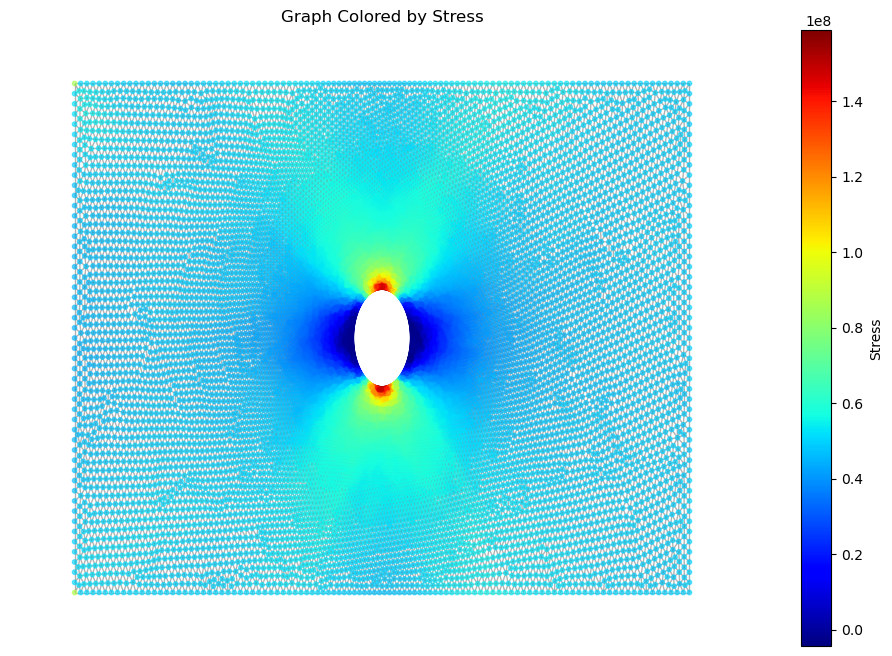

In [212]:
value = sxx

fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6,
        node_color=value, cmap="jet", vmin=value.min(), vmax=value.max(),
        ax=ax)

# Create a mappable and assign the stress values to it for the colorbar
mappable = plt.cm.ScalarMappable(cmap="jet")
mappable.set_array(value)

# Add the colorbar to the figure, using the axis
fig.colorbar(mappable, ax=ax, label="Stress")

ax.set_title("Graph Colored by Stress")
plt.show()

In [203]:
def export_to_vtk(graph, output, filename="output.vtk"):
    components = ['u', 'v', 'sxx', 'syy', 'sxy']

    node_positions = graph.x.cpu().numpy()
    if node_positions.shape[1] == 2:  # If only (x, y) coordinates are given
        node_positions = np.hstack([node_positions, np.zeros((node_positions.shape[0], 1))])  # Append z=0
    out_values = output.cpu().detach().numpy()
    edge_id = graph.edge_index.cpu().T.numpy()

    cells = [('line', edge_id)]

    point_data = {components[i]: out_values[:, i] for i in range(len(components))}

    mesh = meshio.Mesh(points=node_positions, cells=cells, point_data=point_data)
    mesh.write(filename)

In [204]:
data = obj.graph
out = test.model(data)
filename = "data/output.vtk"

export_to_vtk(data, out, filename)